In [1]:
# change to the root directory of the project
import os
print(os.getcwd())

/workspace/cogitate


# Install Packages

In [1]:
# install MNE-Python packages via pip
!pip install mne
!pip install mne_bids
!pip install mne_connectivity
!pip install statsmodels
!pip install matplotlib
!pip install --upgrade jupyterlab ipympl

# Imports

Ensure Matplotlib uses the Qt5Agg backed, which is the best choice for the MNE-Python's interactive plotting functions. We should run the next cell before the other imports, specially the import of matplotlib.pyplot.

In [7]:
import matplotlib

#matplotlib.use("Qt5Agg")

In [10]:
import mne
import mne_bids
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from mne.preprocessing import find_bad_channels_maxwell

In [11]:
from mne_connectivity import spectral_connectivity_epochs
#from statsmodels.tsa.stattools import grangercausalitytests

# Data preparation

## 1. Load MEG data

Adjust the address as needed. If running in Google Colab, comment the sample_data_folder.

In [12]:
# Load data
notebook_root = os.getcwd()
bids_root = notebook_root + f"/ARC-Cogitate-dataset/"
bids_path = mne_bids.BIDSPath(subject="CA103", session='1', task="dur", run="01", root=bids_root)

raw = mne_bids.read_raw_bids(bids_path)

Opening raw data file /workspace/cogitate/ARC-Cogitate-dataset/sub-CA103/ses-1/meg/sub-CA103_ses-1_task-dur_run-01_meg.fif...
    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 9000 ... 852999 =      9.000 ...   852.999 secs
Ready.
Reading events from /workspace/cogitate/ARC-Cogitate-dataset/sub-CA103/ses-1/meg/sub-CA103_ses-1_task-dur_run-01_events.tsv.
Reading channel info from /workspace/cogitate/ARC-Cogitate-dataset/sub-CA103/ses-1/meg/sub-CA103_ses-1_task-dur_run-01_channels.tsv.
Dropping cHPI information stored in raw data, following specification in sidecar file

/tmp/ipykernel_582515/3502198788.py:6: RuntimeWarning: The unit for channel(s) MISC001, MISC002, MISC003, MISC004, MISC005 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [13]:
# Load the data
raw.load_data()

Reading 0 ... 843999  =      0.000 ...   843.999 secs...


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,mne_anonymize
Participant,sub-CA103
Digitized points,270 points
Good channels,"2 EOG, 1 ECG, 11 IAS, 102 Magnetometers, 204 Gradiometers, 5 misc, 15 Stimulus, 1 SYST"
Bad channels,None
EOG channels,"EOG001, EOG002"
ECG channels,ECG003
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,330.00 Hz


In [14]:
# Make report for the dataset
print(mne_bids.make_report(bids_root))

Summarizing participants.tsv /workspace/cogitate/ARC-Cogitate-dataset/participants.tsv...
Summarizing scans.tsv files [PosixPath('/workspace/cogitate/ARC-Cogitate-dataset/sub-CA103/ses-1/sub-CA103_ses-1_scans.tsv')]...
The participant template found: sex were all unknown;
handedness were all unknown;
ages ranged from 18.0 to 34.0 (mean = 22.96, std = 3.72)
 The Cogitate EXP1 MEEG dataset was created by Taheriyan, F., Kahraman, K.,
Sripad, P., Bonacchi, N., Brown, T., Oh, H., and Melloni, L. and conforms to
BIDS version 1.8.0. This report was generated with MNE-BIDS
(https://doi.org/10.21105/joss.01896). The dataset consists of 1 participants
(sex were all unknown; handedness were all unknown; ages ranged from 18.0 to
34.0 (mean = 22.96, std = 3.72)) and 1 recording sessions: 1. Data was recorded
using an MEG system (Elekta) sampled at 1000.0 Hz with line noise at 50.0 Hz.
The following software filters were applied during recording:
SpatialCompensation. There were 7 scans in total. Rec

Get a glimpse of the basic details of the Raw object.

In [15]:
# The info data structure keeps track of channel locations, applied filters, projectors, etc.
print(raw)
print(raw.info)

<Raw | sub-CA103_ses-1_task-dur_run-01_meg.fif, 341 x 844000 (844.0 s), ~2.14 GB, data loaded>
<Info | 21 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: EOG001, EOG002, ECG003, IASX+, IASX-, IASY+, IASY-, IASZ+, ...
 chs: 2 EOG, 1 ECG, 11 IAS, 102 Magnetometers, 204 Gradiometers, 5 misc, 15 Stimulus, 1 SYST
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 dig: 270 items (3 Cardinal, 4 HPI, 263 Extra)
 events: 1 item (list)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.1 Hz
 hpi_results: 1 item (list)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 341
 proj_name: mne_anonymize
 projs: generated with autossp-1.2.0: off, generated with autossp-1.2.0: ...
 sfreq: 1000.0 Hz
 subject_info: 9 items (dict)
>


In [16]:
# Inspect the description
raw.info["description"]

'Anonymized using a time shift to preserve age at acquisition'

In [17]:
# Inspect the first 10 channels
raw.ch_names

['EOG001',
 'EOG002',
 'ECG003',
 'IASX+',
 'IASX-',
 'IASY+',
 'IASY-',
 'IASZ+',
 'IASZ-',
 'IAS_DX',
 'IAS_DY',
 'IAS_X',
 'IAS_Y',
 'IAS_Z',
 'MEG0111',
 'MEG0112',
 'MEG0113',
 'MEG0121',
 'MEG0122',
 'MEG0123',
 'MEG0131',
 'MEG0132',
 'MEG0133',
 'MEG0141',
 'MEG0142',
 'MEG0143',
 'MEG0211',
 'MEG0212',
 'MEG0213',
 'MEG0221',
 'MEG0222',
 'MEG0223',
 'MEG0231',
 'MEG0232',
 'MEG0233',
 'MEG0241',
 'MEG0242',
 'MEG0243',
 'MEG0311',
 'MEG0312',
 'MEG0313',
 'MEG0321',
 'MEG0322',
 'MEG0323',
 'MEG0331',
 'MEG0332',
 'MEG0333',
 'MEG0341',
 'MEG0342',
 'MEG0343',
 'MEG0411',
 'MEG0412',
 'MEG0413',
 'MEG0421',
 'MEG0422',
 'MEG0423',
 'MEG0431',
 'MEG0432',
 'MEG0433',
 'MEG0441',
 'MEG0442',
 'MEG0443',
 'MEG0511',
 'MEG0512',
 'MEG0513',
 'MEG0521',
 'MEG0522',
 'MEG0523',
 'MEG0531',
 'MEG0532',
 'MEG0533',
 'MEG0541',
 'MEG0542',
 'MEG0543',
 'MEG0611',
 'MEG0612',
 'MEG0613',
 'MEG0621',
 'MEG0622',
 'MEG0623',
 'MEG0631',
 'MEG0632',
 'MEG0633',
 'MEG0641',
 'MEG0642',
 'M

In [18]:
# Inspect the chs informations
raw.info['chs'][0]

{'scanno': 1,
 'logno': 1,
 'kind': 202 (FIFFV_EOG_CH),
 'range': 1.0,
 'cal': 0.0005719999899156392,
 'coil_type': 0 (FIFFV_COIL_NONE),
 'loc': array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'EOG001',
 'coord_frame': 0 (FIFFV_COORD_UNKNOWN)}

## 2. Visualize data

Plot the power spectral density (PSD) for each sensor type with compute_psd, as well as a plot of the raw sensor traces with plot.

Effective window size : 2.048 (s)
Using matplotlib as 2D backend.


/opt/conda/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


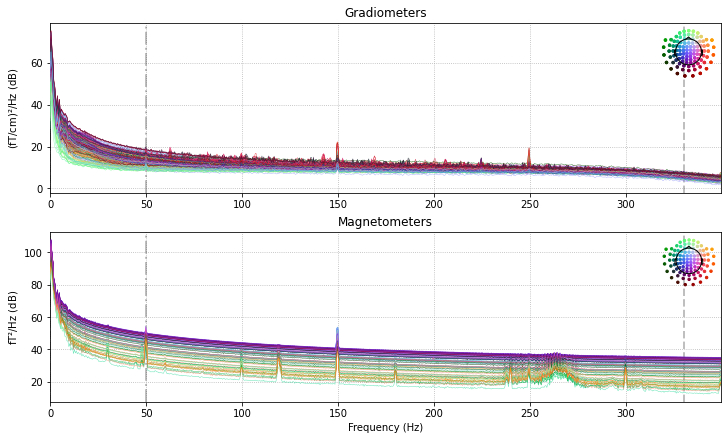

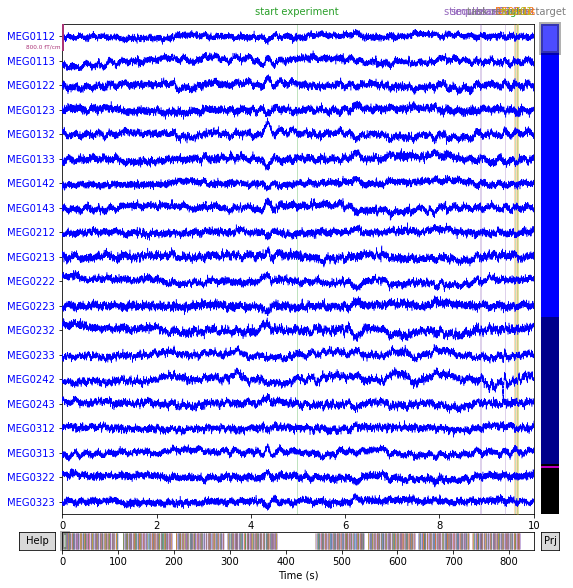

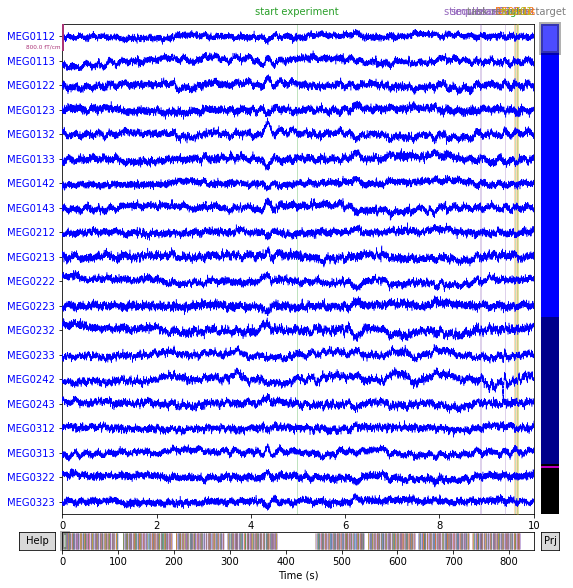

In [13]:
# In the PSD plot, we’ll only plot frequencies below 350 Hz (since our data are low-pass filtered at 330 Hz).
raw.compute_psd(fmax=350).plot(picks="data", exclude="bads", amplitude=False)
raw.plot()

### 2.1. Visualize the sensor locations

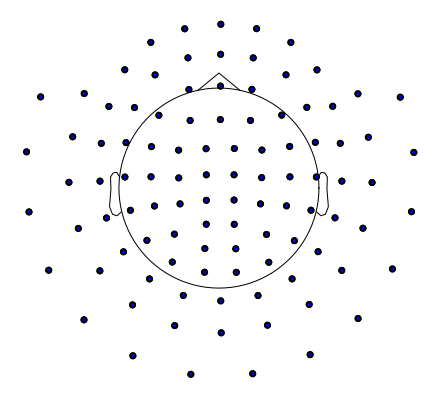

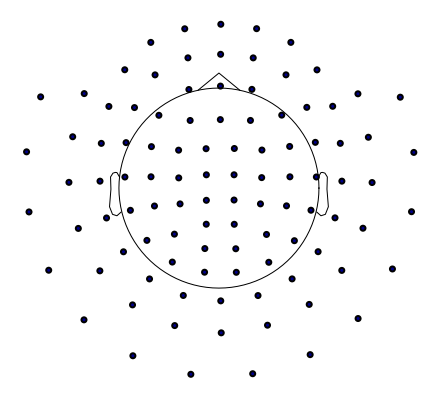

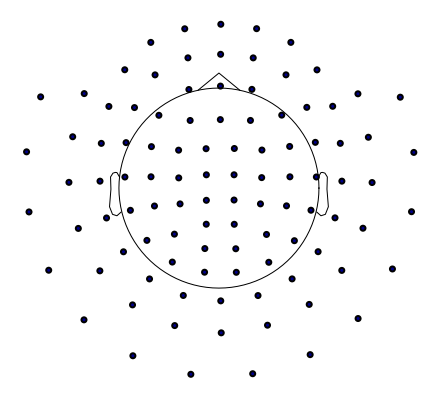

In [14]:
# Gradiometers
raw.plot_sensors(ch_type='grad')

# Magnetometers
raw.plot_sensors(ch_type='mag')

Visualize the sensor locations in 3D format.

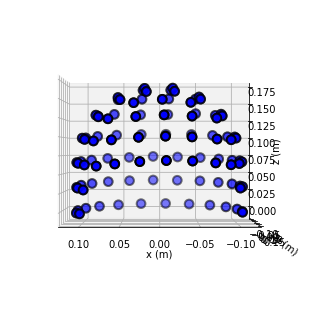

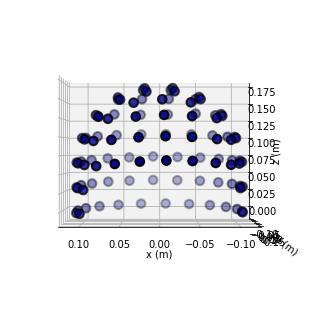

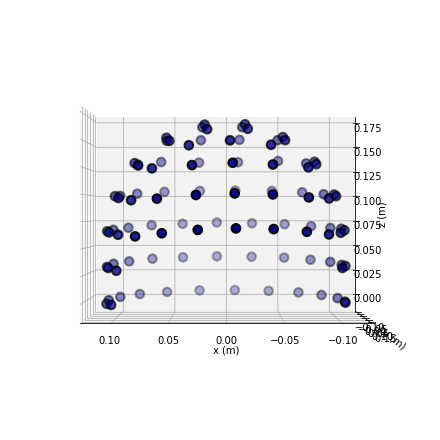

In [15]:
# Gradiometers
raw.plot_sensors(kind='3d', ch_type='grad')

# Magnetometers
raw.plot_sensors(kind='3d', ch_type='mag')

## 3. Detect events

The ARC-Cogitate dataset comprises raw datafiles. Then, the events are stored in a separate .tsv data array file. We need to get the events from an Annotations object to be able to took at the events.

In [19]:
raw.annotations[0]

OrderedDict([('onset', 13.977),
             ('duration', 0.0),
             ('description', 'start experiment'),
             ('orig_time',
              datetime.datetime(2000, 1, 1, 0, 0, tzinfo=datetime.timezone.utc))])


If we look at the events in the STIM channel, they all have the same event ID:

In [35]:
# Define events and create epochs
events = mne.find_events(raw, stim_channel="STI001")
print(events[:10])  # show the first 10

1195 events found on stim channel STI001
Event IDs: [5]
[[17868     0     5]
 [18397     0     5]
 [18605     0     5]
 [18622     0     5]
 [18638     0     5]
 [18655     0     5]
 [19144     0     5]
 [20590     0     5]
 [20790     0     5]
 [20823     0     5]]


If we get the events from annotations, we obtain different event IDs. 

In [36]:
events, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events)

Used Annotations descriptions: ['1000ms', '1500ms', '500ms', 'blank offset', 'center', 'face01', 'face02', 'face03', 'face04', 'face06', 'face07', 'face08', 'face09', 'face10', 'face11', 'face12', 'face13', 'face14', 'face15', 'face16', 'face17', 'face18', 'face19', 'face20', 'false01', 'false02', 'false04', 'false05', 'false06', 'false07', 'false08', 'false09', 'false10', 'false11', 'false12', 'false13', 'false14', 'false15', 'false16', 'false17', 'false18', 'false19', 'false20', 'left', 'letter01', 'letter02', 'letter03', 'letter04', 'letter05', 'letter06', 'letter07', 'letter08', 'letter09', 'letter10', 'letter11', 'letter12', 'letter13', 'letter14', 'letter15', 'letter16', 'letter17', 'letter20', 'object01', 'object02', 'object03', 'object04', 'object05', 'object06', 'object07', 'object08', 'object09', 'object10', 'object11', 'object12', 'object13', 'object14', 'object15', 'object16', 'object17', 'object18', 'object19', 'object20', 'response', 'right', 'sequence01', 'sequence02', '

We can plot the events and check them along time.

/tmp/ipykernel_581390/126485887.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(


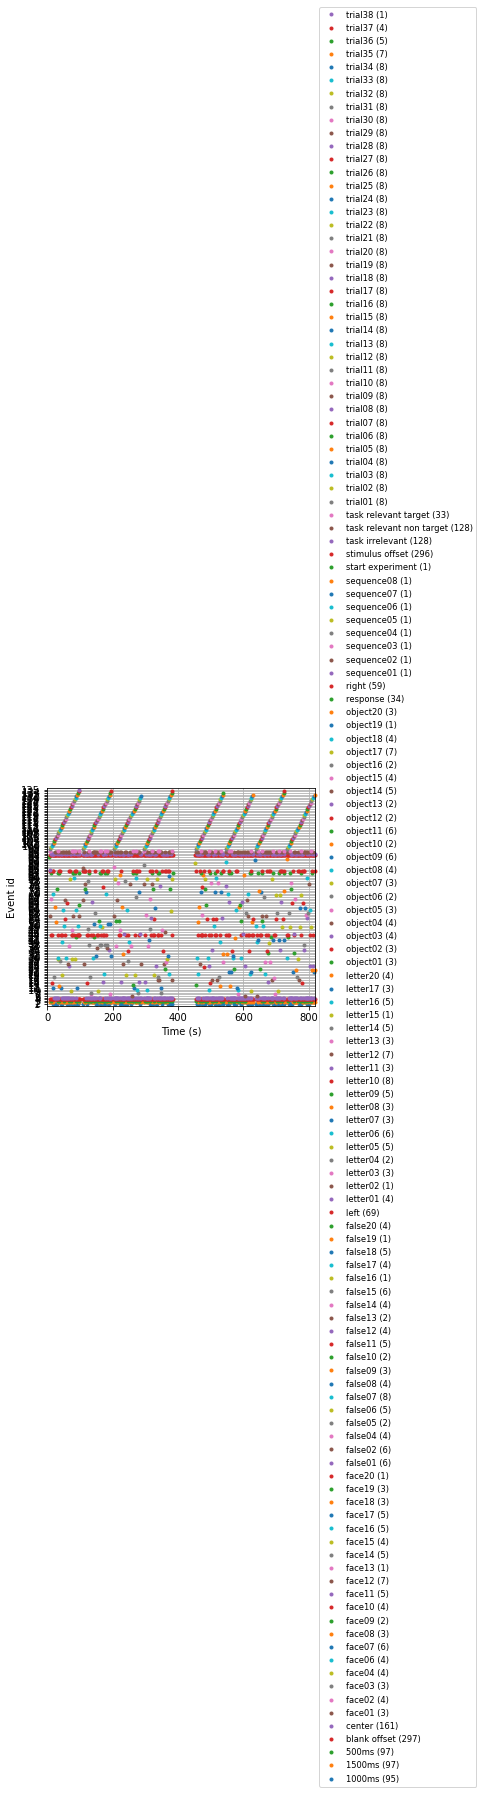

In [19]:
fig = mne.viz.plot_events(
    events, 
    event_id=event_dict, 
    sfreq=raw.info["sfreq"], 
    first_samp=raw.first_samp
)

The annotations appear automatically when plotting the raw data, and are color-coded by their label value:

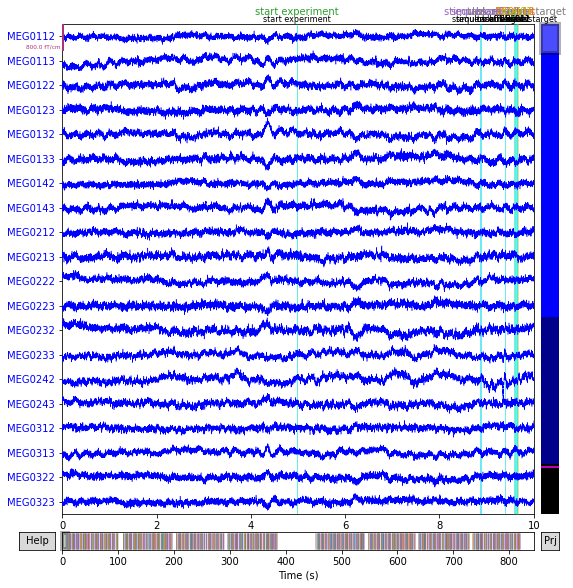

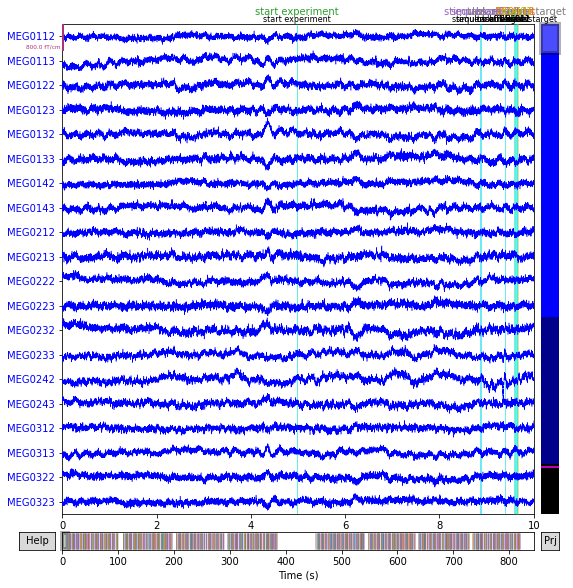

In [20]:
raw.plot(events=events, event_id=event_dict)

## 4. Preprocessing

To preprocess the data, we are going to follow two stepps. First, we are going to suppress the noise. Then, we will identify artifacts and apply ICA to reduce them. 

### 4.1. Noise reduction

Find the MEG fine-calibration and crosstalk files:

In [21]:
fine_cal_file = bids_path.meg_calibration_fpath
crosstalk_file = bids_path.meg_crosstalk_fpath

Identify bad channels:

In [22]:
raw.info["bads"] = []
raw_check = raw.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
    raw_check,
    cross_talk=crosstalk_file,
    calibration=fine_cal_file,
    return_scores=True,
    verbose=True,
)
print(auto_noisy_chs)  # we should find them!
print(auto_flat_chs)  # none for this dataset

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.9s finished


Scanning for bad channels in 168 intervals (5.0 s) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CA103_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 86.1 mm
    Using origin 0.4, -0.3, 54.1 mm in the head frame
        Interval   1:    0.000 -    4.999
        Interval   2:    5.000 -    9.999
        Interval   3:   10.000 -   14.999
        Interval   4:   15.000 -   19.999
        Interval   5:   20.000 -   24.999
        Interval   6:   25.000 -   29.999
        Interval   7:   30.000 -   34.999
        Interval   8:   35.000 -   39.999
        Interval   9:   40.000 -   44.999
        Interval  10:   45.000 -   49.999
        Interval  11:   50.000 -   54.999
        Interval  12:   55.000 -   59.999
        Interval  13:   60.000 -  

Visualize noise channel detection:

1. Gradiometer channels

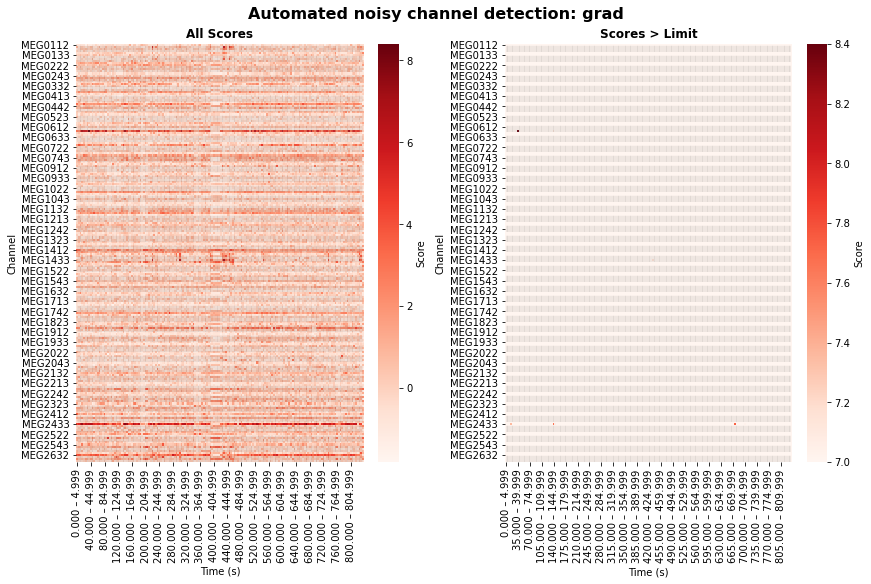

In [23]:
# Only select the data for gradiometer channels.
ch_type = "grad"
ch_subset = auto_scores["ch_types"] == ch_type
ch_names = auto_scores["ch_names"][ch_subset]
scores = auto_scores["scores_noisy"][ch_subset]
limits = auto_scores["limits_noisy"][ch_subset]
bins = auto_scores["bins"]  # The the windows that were evaluated.
# We will label each segment by its start and stop time, with up to 3
# digits before and 3 digits after the decimal place (1 ms precision).
bin_labels = [f"{start:3.3f} – {stop:3.3f}" for start, stop in bins]

# We store the data in a Pandas DataFrame. The seaborn heatmap function
# we will call below will then be able to automatically assign the correct
# labels to all axes.
data_to_plot = pd.DataFrame(
    data=scores,
    columns=pd.Index(bin_labels, name="Time (s)"),
    index=pd.Index(ch_names, name="Channel"),
)

# First, plot the "raw" scores.
fig, ax = plt.subplots(1, 2, figsize=(12, 8), layout="constrained")
fig.suptitle(
    f"Automated noisy channel detection: {ch_type}", fontsize=16, fontweight="bold"
)
sns.heatmap(data=data_to_plot, cmap="Reds", cbar_kws=dict(label="Score"), ax=ax[0])
[
    ax[0].axvline(x, ls="dashed", lw=0.25, dashes=(25, 15), color="gray")
    for x in range(1, len(bins))
]
ax[0].set_title("All Scores", fontweight="bold")

# Now, adjust the color range to highlight segments that exceeded the limit.
sns.heatmap(
    data=data_to_plot,
    vmin=np.nanmin(limits),  # bads in input data have NaN limits
    cmap="Reds",
    cbar_kws=dict(label="Score"),
    ax=ax[1],
)
[
    ax[1].axvline(x, ls="dashed", lw=0.25, dashes=(25, 15), color="gray")
    for x in range(1, len(bins))
]
ax[1].set_title("Scores > Limit", fontweight="bold")
plt.show()

2. Magnetometer channels

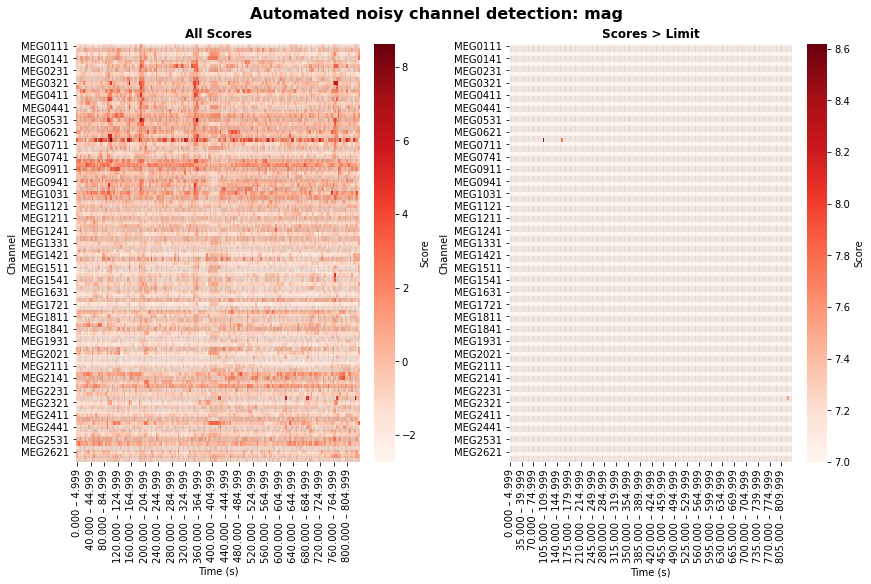

In [24]:
# Only select the data for magnetometer channels.
ch_type = "mag"
ch_subset = auto_scores["ch_types"] == ch_type
ch_names = auto_scores["ch_names"][ch_subset]
scores = auto_scores["scores_noisy"][ch_subset]
limits = auto_scores["limits_noisy"][ch_subset]
bins = auto_scores["bins"]  # The the windows that were evaluated.
# We will label each segment by its start and stop time, with up to 3
# digits before and 3 digits after the decimal place (1 ms precision).
bin_labels = [f"{start:3.3f} – {stop:3.3f}" for start, stop in bins]

# We store the data in a Pandas DataFrame. The seaborn heatmap function
# we will call below will then be able to automatically assign the correct
# labels to all axes.
data_to_plot = pd.DataFrame(
    data=scores,
    columns=pd.Index(bin_labels, name="Time (s)"),
    index=pd.Index(ch_names, name="Channel"),
)

# First, plot the "raw" scores.
fig, ax = plt.subplots(1, 2, figsize=(12, 8), layout="constrained")
fig.suptitle(
    f"Automated noisy channel detection: {ch_type}", fontsize=16, fontweight="bold"
)
sns.heatmap(data=data_to_plot, cmap="Reds", cbar_kws=dict(label="Score"), ax=ax[0])
[
    ax[0].axvline(x, ls="dashed", lw=0.25, dashes=(25, 15), color="gray")
    for x in range(1, len(bins))
]
ax[0].set_title("All Scores", fontweight="bold")

# Now, adjust the color range to highlight segments that exceeded the limit.
sns.heatmap(
    data=data_to_plot,
    vmin=np.nanmin(limits),  # bads in input data have NaN limits
    cmap="Reds",
    cbar_kws=dict(label="Score"),
    ax=ax[1],
)
[
    ax[1].axvline(x, ls="dashed", lw=0.25, dashes=(25, 15), color="gray")
    for x in range(1, len(bins))
]
ax[1].set_title("Scores > Limit", fontweight="bold")
plt.show()

We see some noise spots on the gradiometer and magnetometer plots. Since they appear to be small, there's no need to manually add them to the bad channel list. 

Let's add the bad channels to the raw.info object.

In [25]:
bads = raw.info["bads"] + auto_noisy_chs + auto_flat_chs
raw.info["bads"] = bads

In [26]:
# Check them and analyze if we should manually add more channels based on the plots
raw.info["bads"]

['MEG2433']

Apply Maxwell Filter to the raw data:

In [27]:
raw_sss = mne.preprocessing.maxwell_filter(
    raw, 
    cross_talk=crosstalk_file, 
    calibration=fine_cal_file, 
    verbose=True
)

Maxwell filtering raw data
102 of 102 magnetometer types replaced with T3.
    Bad MEG channels being reconstructed: ['MEG2433']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-CA103_ses-1_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 86.1 mm
    Using origin 0.4, -0.3, 54.1 mm in the head frame
        Using 88/95 harmonic components for    0.000  (73/80 in, 15/15 out)
    Using loaded raw data
    Processing 84 data chunks
[done]


Visualize the data before and after noise reduction:

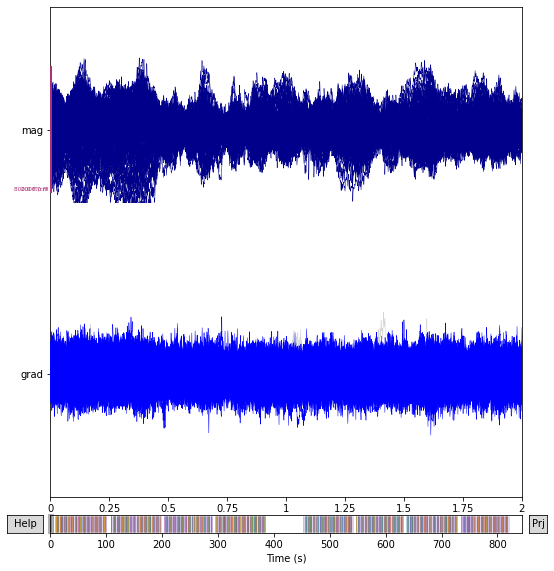

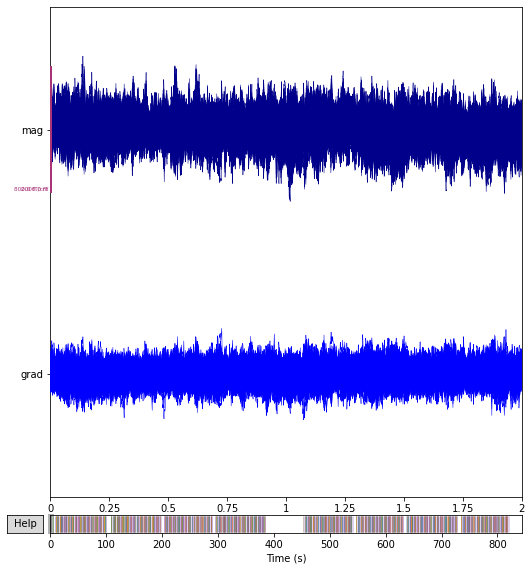

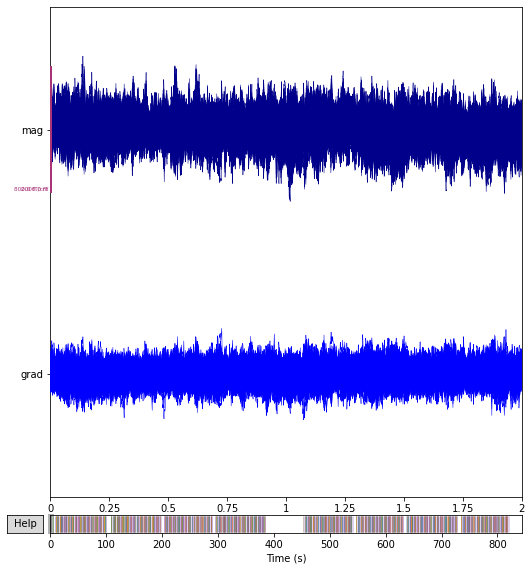

In [28]:
raw.pick(["meg"]).plot(duration=2, butterfly=True, title='Before noise reduction')
raw_sss.pick(["meg"]).plot(duration=2, butterfly=True, title='After noise reduction')

### 4.2. Artifacts reduction (still gonna do it)

In [29]:
# Before preprocessing the data, let's first detect artifacts.

ssp_projectors = raw.info["projs"]
raw.del_proj()

Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,mne_anonymize
Participant,sub-CA103
Digitized points,270 points
Good channels,"102 Magnetometers, 203 Gradiometers"
Bad channels,MEG2433
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,330.00 Hz


Fitting ICA to data using 305 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 36.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
422 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
422 matching events found
No baseline correction applied
0 projection items activated


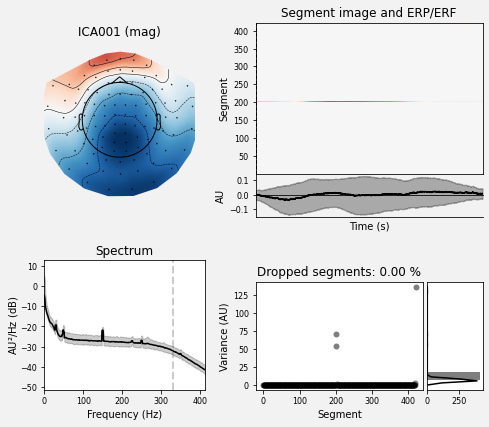

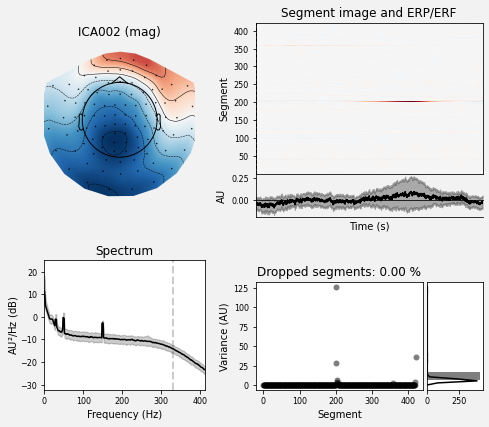

[<Figure size 504x432 with 6 Axes>, <Figure size 504x432 with 6 Axes>]

In [30]:
# Preprocessing (e.g., filtering, artifact removal)
# set up and fit the ICA
# cleans up our data by performing independent components analysis (ICA)

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [1, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude)

## 5. Epoching the data

### 5.1. Creating epochs

Creating epochs means segmenting the data according to the condition-specific events.

In [31]:
# Define variables
tmin = -0.25
tmax = 1.75
baseline = (None, 0)

# Create epochs
epochs = mne.Epochs(
    raw_sss,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    preload=True,
)

epochs

Not setting metadata
2081 matching events found
Setting baseline interval to [-0.25, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2081 events and 2001 original time points ...
0 bad epochs dropped


Number of events,2081
Events,1000ms: 951500ms: 97500ms: 97blank offset: 297center: 161face01: 3face02: 4face03: 3face04: 4face06: 4face07: 6face08: 3face09: 2face10: 4face11: 5face12: 7face13: 1face14: 5face15: 4face16: 5face17: 5face18: 3face19: 3face20: 1false01: 6false02: 6false04: 4false05: 2false06: 5false07: 8false08: 4false09: 3false10: 2false11: 5false12: 4false13: 2false14: 4false15: 6false16: 1false17: 4false18: 5false19: 1false20: 4left: 69letter01: 4letter02: 1letter03: 3letter04: 2letter05: 5letter06: 6letter07: 3letter08: 3letter09: 5letter10: 8letter11: 3letter12: 7letter13: 3letter14: 5letter15: 1letter16: 5letter17: 3letter20: 4object01: 3object02: 3object03: 4object04: 4object05: 3object06: 2object07: 3object08: 4object09: 6object10: 2object11: 6object12: 2object13: 2object14: 5object15: 4object16: 2object17: 7object18: 4object19: 1object20: 3response: 34right: 59sequence01: 1sequence02: 1sequence03: 1sequence04: 1sequence05: 1sequence06: 1sequence07: 1sequence08: 1start experiment: 1stimulus offset: 296task irrelevant: 128task relevant non target: 128task relevant target: 33trial01: 8trial02: 8trial03: 8trial04: 8trial05: 8trial06: 8trial07: 8trial08: 8trial09: 8trial10: 8trial11: 8trial12: 8trial13: 8trial14: 8trial15: 8trial16: 8trial17: 8trial18: 8trial19: 8trial20: 8trial21: 8trial22: 8trial23: 8trial24: 8trial25: 8trial26: 8trial27: 8trial28: 8trial29: 8trial30: 8trial31: 8trial32: 8trial33: 8trial34: 8trial35: 7trial36: 5trial37: 4trial38: 1
Time range,-0.250 – 1.750 s
Baseline,-0.250 – 0.000 s


Visualize the epochs:

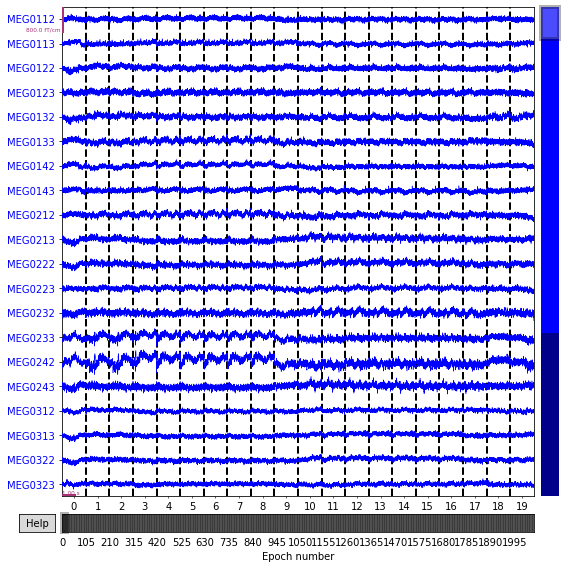

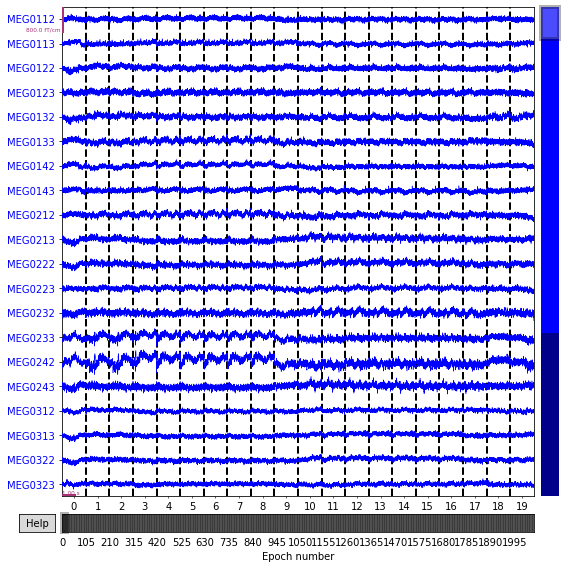

In [32]:
epochs.plot()

Select epochs based on experimental conditions:

In [33]:
epochs['right']

Number of events,59
Events,right: 59
Time range,-0.250 – 1.750 s
Baseline,-0.250 – 0.000 s


In [34]:
epochs['left']

Number of events,69
Events,left: 69
Time range,-0.250 – 1.750 s
Baseline,-0.250 – 0.000 s


Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"
combining channels using "gfp"


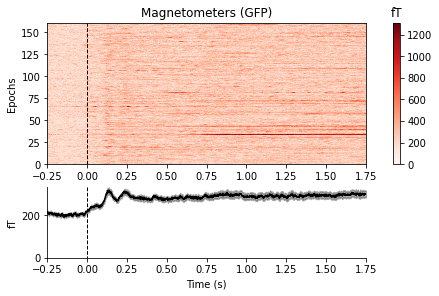

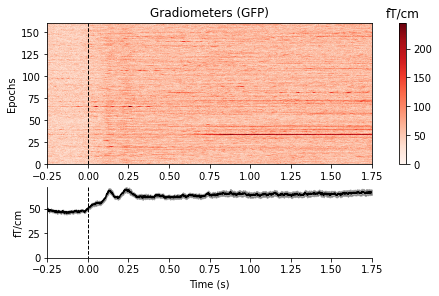

[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

In [35]:
epochs['center'].plot_image()

### 5.2. Saving epochs

In [36]:
epochs.save(notebook_root + '/SUB103_ses-1_task-dur_run-01_epochs-epo.fif',
           overwrite=True)

Splitting into 3 parts


### 5.3. Creating evoked data

In [37]:
evoked_left = epochs['left'].average()
evoked_right = epochs['right'].average()
evoked_center = epochs['center'].average()

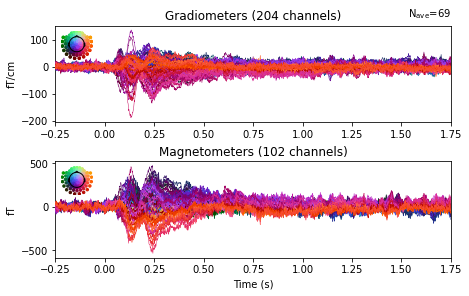

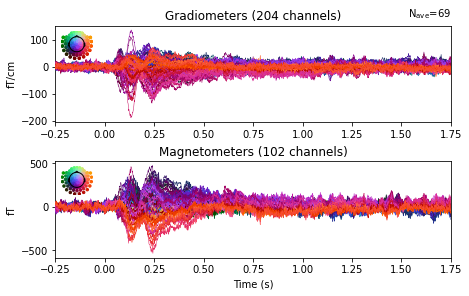

In [38]:
evoked_left.plot(spatial_colors=True)

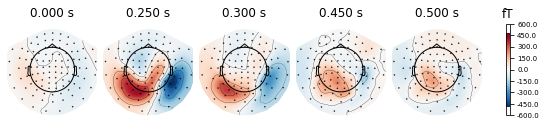

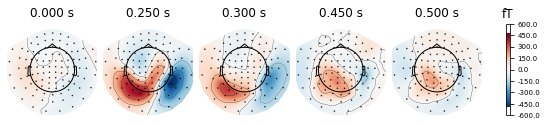

In [39]:
evoked_left.plot_topomap(ch_type='mag', times=[0, 0.250, 0.300, 0.450, 0.500])

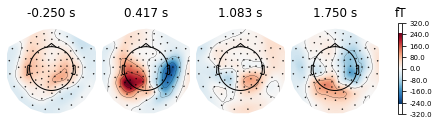

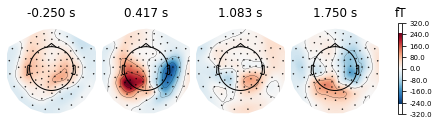

In [40]:
evoked_right.plot_topomap(ch_type='mag')

No projector specified for this dataset. Please consider the method self.add_proj.


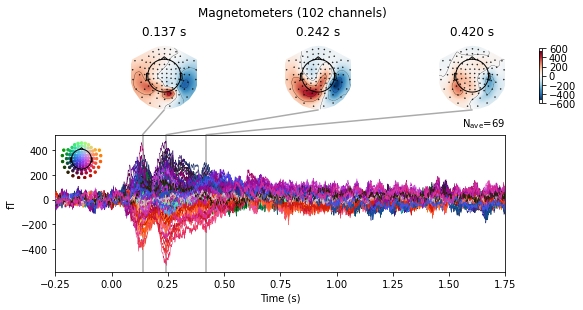

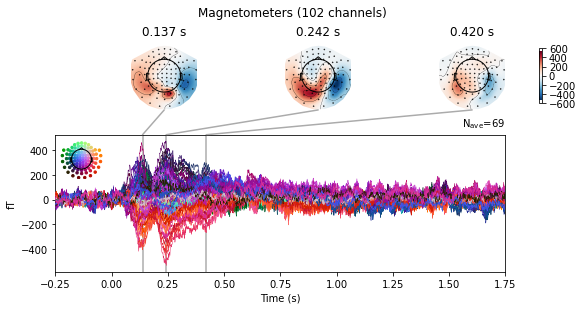

In [41]:
evoked_left.plot_joint(picks='mag')

combining channels using "gfp"
combining channels using "gfp"


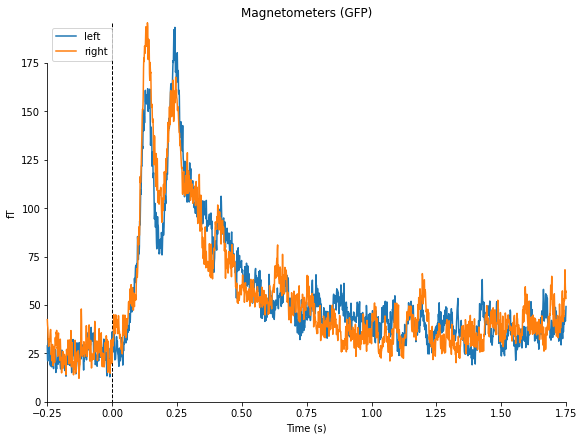

[<Figure size 576x432 with 1 Axes>]

In [42]:
mne.viz.plot_compare_evokeds([evoked_left, evoked_right], picks='mag')

### 5.4. Saving evoked data

It's possible to do it, but it's rarely done, since it's computationally cheap to generate them from the epochs. 